# School TOD Categories

Model 1: Estimates arrival time at schools.<br>
Model 2: Estimates departure time from schools. 

Note: Contrary to Home-work-home trips, model 2 estimates departure time from school rather than dwell time at school. 

TO DO: 
 - Improve model specification
 - Check urbansim_templates.models.SmallMultinomialStep() functionality. It seems is not working properly. 

In [404]:
from collections import OrderedDict
from urbansim_templates import modelmanager as mm
from urbansim_templates.models import LargeMultinomialLogitStep
from urbansim_templates.models import SmallMultinomialLogitStep
import orca
import os; os.chdir('../')
import warnings; warnings.simplefilter('ignore')

import pandas as pd
# import pandana as pdna
import time
import numpy as np
import matplotlib.pyplot as plt
import os
from functools import reduce

import scipy.stats as st
from scipy.stats import skewnorm
import pylogit as pl
import random

import pickle
import dill

# import matplotlib
# matplotlib.style.use('ggplot')

%matplotlib inline

pd.options.display.max_columns = 80

## Loading data 

In [355]:
trips = pd.read_csv('/home/emma/ual_model_workspace/spring-2019-models/notebooks-emma/HStrips_031219.csv', index_col = 0)

In [356]:
trips

,HHPER,HHPERTRIP,origin,origin_dwell,origin_ST,origin_ET,trip_ET,TT,MODE
0,10320533,1.032053e+09,home,13.750000,17.750000,7.500000,7.550000,0.050000,shared
1,10320533,1.032053e+09,school,8.616667,7.550000,16.166667,17.750000,1.583333,shared
2,10320534,1.032053e+09,home,13.750000,17.750000,7.500000,7.550000,0.050000,shared
3,10320534,1.032053e+09,school,8.616667,7.550000,16.166667,17.750000,1.583333,shared
4,10320535,1.032054e+09,home,14.833333,16.666667,7.500000,7.550000,0.050000,shared
5,10320535,1.032054e+09,school,8.616667,7.550000,16.166667,16.666667,0.500000,shared
6,10351982,1.035198e+09,home,10.416667,19.583333,6.000000,16.833333,10.833333,drive_alone
7,10351982,1.035198e+09,school,2.416667,16.833333,19.250000,19.583333,0.333333,drive_alone
8,10379521,1.037952e+09,home,21.833333,8.166667,6.000000,6.250000,0.250000,walk
9,10379521,1.037952e+09,school,1.750000,6.250000,8.000000,8.166667,0.166667,walk


# Creating TOD categories for school arrival time and school departure time

In [357]:
#select people who make both home-school and school-home trips:
tripsII = trips.groupby('HHPER').filter(lambda x: len(x) == 2)

In [358]:
#make sure all home-school trip rows are listed first
tripsIII = tripsII.sort_values(['HHPER','origin'])

#move school-home trip info up into home-school trip rows
tripsIII['school_dwell'] = tripsIII.groupby('HHPER', group_keys=False).origin_dwell.shift(-1)
tripsIII['school_ST'] = tripsIII.groupby('HHPER', group_keys=False).origin_ST.shift(-1)
tripsIII['SH_trip_ST'] = tripsIII.groupby('HHPER', group_keys=False).origin_ET.shift(-1)
tripsIII['SH_trip_ET'] = tripsIII.groupby('HHPER', group_keys=False).trip_ET.shift(-1)
tripsIII['SH_TT'] = tripsIII.groupby('HHPER', group_keys=False).TT.shift(-1)
tripsIII['SH_mode'] = tripsIII.groupby('HHPER', group_keys=False).MODE.shift(-1)

In [359]:
tripsIII = tripsIII.groupby('HHPER').first().reset_index()

In [360]:
tripsIII.rename(columns = {'origin_dwell':'home_dwell','origin_ST':'home_ST','origin_ET':'HS_trip_ST',
                           'trip_ET':'HS_trip_ET','TT':'HS_TT','MODE':'HS_mode','TOD':'HS_TOD'},inplace = True)

In [363]:
#School arrival time TOD category
tripsIII['School_arrival_TOD'] = pd.cut(tripsIII.HS_trip_ET, 
                             np.array([0, 3.0, 7.75, 8.5, 9.5, 15.0, 24.0]), 
                             labels = [6,1,2,3,4,5]).replace(6,5).astype(int)

#School departure time TOD category
tripsIII['School_departure_TOD'] = pd.cut(tripsIII.SH_trip_ST, 
                             np.array([0, 10, 12, 15, 17, 20, 24]), 
                             labels = [6,1,2,3,4,5]).replace(6, 5).astype(int)

In [364]:
tripsIII

,HHPER,HHPERTRIP,origin,home_dwell,home_ST,HS_trip_ST,HS_trip_ET,HS_TT,HS_mode,school_dwell,school_ST,SH_trip_ST,SH_trip_ET,SH_TT,SH_mode,School_arrival_TOD,School_departure_TOD
0,10320533,1.032053e+09,home,13.750000,17.750000,7.500000,7.550000,0.050000,shared,8.616667,7.550000,16.166667,17.750000,1.583333,shared,1,3
1,10320534,1.032053e+09,home,13.750000,17.750000,7.500000,7.550000,0.050000,shared,8.616667,7.550000,16.166667,17.750000,1.583333,shared,1,3
2,10320535,1.032054e+09,home,14.833333,16.666667,7.500000,7.550000,0.050000,shared,8.616667,7.550000,16.166667,16.666667,0.500000,shared,1,3
3,10351982,1.035198e+09,home,10.416667,19.583333,6.000000,16.833333,10.833333,drive_alone,2.416667,16.833333,19.250000,19.583333,0.333333,drive_alone,5,4
4,10379521,1.037952e+09,home,21.833333,8.166667,6.000000,6.250000,0.250000,walk,1.750000,6.250000,8.000000,8.166667,0.166667,walk,1,5
5,10413053,1.041305e+09,home,15.750000,15.000000,6.750000,6.916667,0.166667,shared,7.833333,6.916667,14.750000,15.000000,0.250000,bike,1,2
6,10417663,1.041766e+09,home,13.250000,18.750000,8.000000,8.500000,0.500000,shared,9.666667,8.500000,18.166667,18.750000,0.583333,shared,2,4
7,10420111,1.042011e+09,home,18.000000,14.500000,8.500000,8.750000,0.250000,drive_alone,5.250000,8.750000,14.000000,14.500000,0.500000,shared,3,2
8,10436131,1.043613e+09,home,15.733333,21.733333,13.466667,17.500000,4.033333,drive_alone,3.666667,17.500000,21.166667,21.733333,0.566667,drive_alone,5,5
9,10447671,1.044767e+09,home,22.250000,15.500000,13.750000,14.000000,0.250000,walk,0.416667,14.000000,14.416667,15.500000,1.083333,walk,4,2


## Add the demographic variables

In [365]:
person = pd.read_csv('/home/data/CHTS_csv_format/data/Deliv_PER.csv')
person[person.SAMPN == 1032053]

,SAMPN,PERNO,RELAT,GEND,AGE,AGEB,HISP,RACE1,RACE2,RACE3,RACE4,O_RACE,NTVTY,CNTRY,LIC,USER,TRANS,TPTYP1,TPTYP2,TPTYP3,TPTYP4,TPTYP5,TPTYP6,TPTYP7,O_TPTYP,CLIP1,CLIP2,CLIP3,COMP,MET,PASSTL,FLEX,EMPLY,WKSTAT,O_WKSTAT,JOBS,WLOC,WNAME,WCITY,WSTAT,...,HVLOG,PTRIPS,TOLLF,TOLLR1,TOLLR2,TOLLR3,TOLLR4,TOLLR5,TOLLR6,TOLLR7,TOLLR8,TOLLR9,TOLLR10,TOLLB1,TOLLB2,TOLLB3,TOLLB4,TOLLB5,TOLLB6,TOLLB7,TOLLB8,TOLLB9,TOLLB10,HOVL,NOGOWHY,NOGOWHY_O,InComplete,Moto_trip,WCTFIP,WTRACT,SCTFIP,STRACT,WPrimaryCity,WSTFIP,W2PrimaryCity,W2STFIP,SPrimaryCity,SSTFIP,PERWGT,EXPPERWGT
7,1032053,1,1,2,30,NaN,1,1.0,NaN,NaN,NaN,NaN,1,NaN,1.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,1.0,NaN,NaN,1.0,1.0,HIDDEN,MODESTO,CA,...,1.0,15.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,1.0,99.0,504.0,NaN,NaN,MODESTO,6.0,NaN,NaN,NaN,NaN,0.134135,45.447024
8,1032053,2,2,1,31,NaN,1,97.0,NaN,NaN,NaN,HISPANIC,2,9998.0,2.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,8.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.094628,32.061393
9,1032053,3,3,2,9,NaN,1,97.0,NaN,NaN,NaN,HISPANIC,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,5.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,1.0,NaN,NaN,47.0,1602.0,NaN,NaN,NaN,NaN,MERCED,6.0,0.059297,20.090794
10,1032053,4,3,2,7,NaN,1,97.0,NaN,NaN,NaN,HISPANIC,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,5.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,1.0,NaN,NaN,47.0,1602.0,NaN,NaN,NaN,NaN,MERCED,6.0,0.059297,20.090794
11,1032053,5,3,2,5,NaN,1,97.0,NaN,NaN,NaN,HISPANIC,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,5.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,1.0,NaN,NaN,47.0,1602.0,NaN,NaN,NaN,NaN,MERCED,6.0,0.059297,20.090794
12,1032053,6,3,1,1,NaN,1,97.0,NaN,NaN,NaN,HISPANIC,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,8.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.059297,20.090794


In [366]:
person = person[['SAMPN','PERNO','GEND','AGE','HISP','RACE1','RACE2','RACE3','RACE4',
                 'EDUCA']]

In [367]:
person['HHPER'] = person['SAMPN'].map(str) + person['PERNO'].map(str)

In [368]:
hh_df = pd.read_csv('/home/data/CHTS_csv_format/data/Deliv_HH.csv')[
  ['SAMPN','HHVEH','OWN','INCOM','HHSIZ']]

In [369]:
demo = person.merge(hh_df,on = 'SAMPN',how = 'left')

demo.HHPER.nunique()

109113

In [370]:
demo

,SAMPN,PERNO,GEND,AGE,HISP,RACE1,RACE2,RACE3,RACE4,EDUCA,HHPER,HHVEH,OWN,INCOM,HHSIZ
0,1031985,1,1,74,2,1.0,NaN,NaN,NaN,6,10319851,2,1,3,2
1,1031985,2,2,73,2,1.0,NaN,NaN,NaN,6,10319852,2,1,3,2
2,1032036,1,1,46,2,1.0,NaN,NaN,NaN,6,10320361,1,1,7,5
3,1032036,2,2,47,2,1.0,97.0,NaN,NaN,6,10320362,1,1,7,5
4,1032036,3,1,15,2,1.0,97.0,NaN,NaN,1,10320363,1,1,7,5
5,1032036,4,1,14,2,1.0,97.0,NaN,NaN,1,10320364,1,1,7,5
6,1032036,5,1,7,2,1.0,97.0,NaN,NaN,1,10320365,1,1,7,5
7,1032053,1,2,30,1,1.0,NaN,NaN,NaN,3,10320531,2,2,2,6
8,1032053,2,1,31,1,97.0,NaN,NaN,NaN,1,10320532,2,2,2,6
9,1032053,3,2,9,1,97.0,NaN,NaN,NaN,1,10320533,2,2,2,6


In [371]:
na_dict = {
    'GEND':[9],
    'AGE':[998,999],
    'EDUCA':[8,9],
    'HHVEH':[98,99],
    'OWN':[7,8,9],
    'INCOM':[98,99],
    'HHSIZ':[98,99]
}

for col in na_dict:
    for vals in na_dict[col]:
        demo[col] = demo[col].replace(vals,np.nan)

In [372]:
demo.isnull().sum()

SAMPN         0
PERNO         0
GEND        311
AGE        3924
HISP          0
RACE1         5
RACE2    104862
RACE3    108879
RACE4    109090
EDUCA      2088
HHPER         0
HHVEH         0
OWN         339
INCOM      8839
HHSIZ         0
dtype: int64

In [373]:
demo = demo.dropna(subset = ['GEND', 'AGE', 'EDUCA','HHVEH','OWN','INCOM','HHSIZ'])

In [374]:
demo.shape

(95912, 15)

In [375]:
tripsIII['HHPER'] = tripsIII['HHPER'].map(str)

trips1 = pd.merge(tripsIII, demo, on='HHPER')

print (len(tripsIII.index))
print (len(trips1.index))

9857
8997


In [376]:
#Selecting K-12 trips that are more likeley to be K-12 studnets. 
trips_final = trips1[(trips1.AGE <= 18) & (trips1.EDUCA <= 2)]

In [377]:
trips_final.columns

Index(['HHPER', 'HHPERTRIP', 'origin', 'home_dwell', 'home_ST', 'HS_trip_ST',
       'HS_trip_ET', 'HS_TT', 'HS_mode', 'school_dwell', 'school_ST',
       'SH_trip_ST', 'SH_trip_ET', 'SH_TT', 'SH_mode', 'School_arrival_TOD',
       'School_departure_TOD', 'SAMPN', 'PERNO', 'GEND', 'AGE', 'HISP',
       'RACE1', 'RACE2', 'RACE3', 'RACE4', 'EDUCA', 'HHVEH', 'OWN', 'INCOM',
       'HHSIZ'],
      dtype='object')

## Prepate data for estimation 

In [378]:
# trips_final.isnull().sum()

In [379]:
trips_final['minority'] = np.where((trips_final['HISP'].isin([1.0]) |
                                trips_final['RACE1'].isin([2.0]) | trips_final['RACE2'].isin([2.0]) | trips_final['RACE3'].isin([2.0]) | trips_final['RACE4'].isin([2.0]) |
                              trips_final['RACE1'].isin([3.0]) | trips_final['RACE2'].isin([3.0]) | trips_final['RACE3'].isin([3.0]) | trips_final['RACE4'].isin([3.0]) |
                              trips_final['RACE1'].isin([4.0]) | trips_final['RACE2'].isin([4.0]) | trips_final['RACE3'].isin([4.0]) | trips_final['RACE4'].isin([4.0]) |
                              trips_final['RACE1'].isin([5.0]) | trips_final['RACE2'].isin([5.0]) | trips_final['RACE3'].isin([5.0]) | trips_final['RACE4'].isin([5.0]) |
                              trips_final['RACE1'].isin([97.0]) | trips_final['RACE2'].isin([97.0]) | trips_final['RACE3'].isin([97.0]) | trips_final['RACE4'].isin([97.0])),1,0)

# trips_final['black'] = np.where((trips1['RACE1'].isin([2.0]) | trips1['RACE2'].isin([2.0]) | trips1['RACE3'].isin([2.0]) | trips1['RACE4'].isin([2.0])),1,0)
# trips_final['native'] = np.where((trips1['RACE1'].isin([3.0]) | trips1['RACE2'].isin([3.0]) | trips1['RACE3'].isin([3.0]) | trips1['RACE4'].isin([3.0])),1,0)
# trips_final['asian'] = np.where((trips1['RACE1'].isin([4.0]) | trips1['RACE2'].isin([4.0]) | trips1['RACE3'].isin([4.0]) | trips1['RACE4'].isin([4.0])),1,0)

In [380]:
#Race variables
trips_final['black']  = np.where((trips_final['RACE1'].isin([2.0]) | trips_final['RACE2'].isin([2.0]) | trips_final['RACE3'].isin([2.0]) | trips_final['RACE4'].isin([2.0])),1,0)
trips_final['native'] = np.where((trips_final['RACE1'].isin([3.0]) | trips_final['RACE2'].isin([3.0]) | trips_final['RACE3'].isin([3.0]) | trips_final['RACE4'].isin([3.0])),1,0)
trips_final['asian']  = np.where((trips_final['RACE1'].isin([4.0]) | trips_final['RACE2'].isin([4.0]) | trips_final['RACE3'].isin([4.0]) | trips_final['RACE4'].isin([4.0])),1,0)

In [381]:
#Income Varibles 
trips_final['hh_inc_under_25k'] = (trips_final.INCOM.between(0,2, inclusive = True )).astype(int)
trips_final['hh_inc_25_to_75k'] = (trips_final.INCOM.between(3,5, inclusive = True )).astype(int)
trips_final['hh_inc_75_to_200k'] = (trips_final.INCOM.between(6,8, inclusive = True )).astype(int)
trips_final['hh_inc_over_200k'] = (trips_final.INCOM.between(9,10, inclusive = True )).astype(int)

In [382]:
#Age variables 
trips_final['age_0_5'] = (trips_final.AGE.between(0,4, inclusive = True )).astype(int)
trips_final['age_5_12'] = (trips_final.AGE.between(5,11, inclusive = True )).astype(int)
trips_final['age_12_15'] = (trips_final.AGE.between(12,14, inclusive = True )).astype(int)
trips_final['age_15_18'] = (trips_final.AGE.between(15,18, inclusive = True )).astype(int)

In [383]:
#Education variables
trips_final['lessGED'] = np.where(trips_final['EDUCA'].isin([1.0]),1,0)
trips_final['GEDsomeBach'] = np.where(trips_final['EDUCA'].isin([2.0,3.0]),1,0)

In [384]:
#Gender variable. 1 Famale, 0 Male. 
trips_final['female'] = trips_final['GEND'] - 1 

In [385]:
#Homw ownership
trips_final['own_home'] = (trips_final.OWN == 1).astype(int)
trips_final['rent_home'] = (trips_final.OWN == 2).astype(int)

In [386]:
#No veh in the household
trips_final['noveh'] = (trips_final.HHVEH == 0).astype(int)

In [387]:
#HH size 
trips_final['hh_size_over_4'] = np.where(trips_final.HHSIZ.between(4,8,inclusive = True),1,0)

In [432]:
trips_final['person_id'] = trips_final['HHPER']

In [389]:
# #Not suitable for simulation 
# #Education variables
# trips_final['lessGED'] = np.where(trips_final['EDUCA'].isin([1.0]),1,0)
# trips_final['GEDsomeBach'] = np.where(trips_final['EDUCA'].isin([2.0,3.0]),1,0)


# #Gender variable
# trips_final['female'] = trips_final['GEND'] - 1

# #Vehicle ownership variables 
# trips_final['tenure_2'] = trips_final['OWN'] - 1
# trips_final['noveh'] = np.where(trips_final.HHVEH.isin([0.0]),1,0)

# #HH size 
# trips_final['hh_size_4plusper'] = np.where(trips_final.HHSIZ.between(4,8,inclusive = True),1,0)


# #Time of the day dummies. 
# trips_final['TOD_3to745'] = np.where(trips_final['School_arrival_TOD'].isin([0]),1,0)
# trips_final['TOD_830to930'] = np.where(trips_final['School_arrival_TOD'].isin([2]),1,0)
# trips_final['TOD_930to1500'] = np.where(trips_final['School_arrival_TOD'].isin([3]),1,0)
# trips_final['TOD_1500up'] = np.where(trips_final['School_arrival_TOD'].isin([4]),1,0)

## Estimation 

### School arrival time 

In [433]:
#Converting wide to long format 
#I need to trick pylogits function with alternative specific variable - Note that we don't truly have them for this case. 

#Creating a fake alternative specific varible and its corresponding availability variable. 
for x in [1,2,3,4,5]:
    name = 'tt_'+str(x)
    av_name = 'av_'+str(x)
    trips_final[name] = [random.randint(1,20) for x in range(len(trips_final))]
    trips_final[av_name] = 1
    
#Preparing for transformation
ind_variables = ['minority', 'black','native', 'asian', 'hh_inc_under_25k', 'hh_inc_25_to_75k',
                 'hh_inc_75_to_200k', 'hh_inc_over_200k', 'age_0_5', 'age_5_12','age_12_15', 
                 'age_15_18',  'female','own_home', 'rent_home', 'noveh', 'hh_size_over_4']

alt_varying_variables = {u'travel_time': dict([(1, 'tt_1'),
                                               (2, 'tt_2'),
                                               (3, 'tt_3'),
                                               (4, 'tt_4'),
                                               (5, 'tt_5')])}

availability_variables = dict(zip(range(1, 6), ['av_1','av_2','av_3','av_4','av_5']))

# Perform the desired conversion
trips_long = pl.convert_wide_to_long(wide_data= trips_final,
                                       ind_vars = ind_variables,
                                       alt_specific_vars = alt_varying_variables,
                                       availability_vars = availability_variables, 
                                       obs_id_col = 'person_id',
                                       choice_col= 'School_arrival_TOD')

In [434]:
example_specification = OrderedDict()
example_names = OrderedDict()

example_specification["intercept"] = [2, 3, 4, 5]
example_names["intercept"] = ['TOD_2', 'TOD_3', 'TOD_4', 'TOD_5' ]

example_specification["age_5_12"] = [2, 3, 4, 5]
example_names["age_5_12"] = ['age_5_12_2', 'age_5_12_3', 'age_5_12_4', 'age_5_12_5' ]

example_specification["age_12_15"] = [2, 3, 4, 5]
example_names["age_12_15"] = ['age_12_15_2', 'age_12_15_3', 'age_12_15_4', 'age_12_15_5' ]

example_specification["age_15_18"] = [2, 3, 4, 5]
example_names["age_15_18"] = ['age_15_18_2', 'age_15_18_3', 'age_15_18_4', 'age_15_18_5' ]


In [436]:
S_TOD_Categories = pl.create_choice_model(data=trips_long,
                                     alt_id_col='alt_id',
                                     obs_id_col='person_id',
                                     choice_col='School_arrival_TOD',
                                     specification=example_specification,
                                     model_type="MNL",
                                     names=example_names)

S_TOD_Categories.fit_mle(np.zeros(16))
S_TOD_Categories.get_statsmodels_summary()

Log-likelihood at zero: -12,552.0063
Initial Log-likelihood: -12,552.0063
Estimation Time for Point Estimation: 0.50 seconds.
Final log-likelihood: -7,940.2155


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Multinomial Logit Model Regression Results                    
===================================================================================
Dep. Variable:          School_arrival_TOD   No. Observations:                7,799
Model:             Multinomial Logit Model   Df Residuals:                    7,783
Method:                                MLE   Df Model:                           16
Date:                     Thu, 15 Aug 2019   Pseudo R-squ.:                   0.367
Time:                             16:29:16   Pseudo R-bar-squ.:               0.366
AIC:                            15,912.431   Log-Likelihood:             -7,940.215
BIC:                            16,023.819   LL-Null:                   -12,552.006
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
TOD_2           0.4549      0.114      3.978      0.000       0.231       0.679
TOD_3           0.2086      0.120      1.733      0.083      -0.027       0.445
TOD_4          -0.6852      0.155     -4.435      0.000      -0.988      -0.382
TOD_5          -4.1352      0.713     -5.802      0.000      -5.532      -2.738
age_5_12_2      0.3196      0.121      2.648      0.008       0.083       0.556
age_5_12_3     -1.2672      0.136     -9.328      0.000      -1.534      -1.001
age_5_12_4     -1.9539      0.198     -9.871      0.000      -2.342      -1.566
age_5_12_5     -1.1429      0.842     -1.357      0.175      -2.793       0.507
age_12_15_2    -0.3819      0.125     -3.054      0.002      -0.627      -0.137
age_12_15_3    -1.8839      0.151    -12.446      0.000      -2.181      -1.587
age_12_15_4    -2.9432      0.274    -10.733      0.000      -3.481      -2.406
age_12_15_5    -2.4889      1.229     -2.026      0.043      -4.897      -0.081
age_15_18_2    -0.8098      0.124     -6.529      0.000      -1.053      -0.567
age_15_18_3    -2.3219      0.153    -15.205      0.000      -2.621      -2.023
age_15_18_4    -1.8297      0.191     -9.565      0.000      -2.205      -1.455
age_15_18_5    -0.3374      0.770     -0.438      0.661      -1.846       1.171
===============================================================================
"""

In [437]:
#Creating a pkl file
file_Name = "/home/juan/activitysynth/activitysynth/configs/TOD_school_arrival.pkl"
fileObject = open(file_Name,'wb') 
dill.dump(S_TOD_Categories,fileObject)   
fileObject.close()


In [438]:
#Testing pkl file
fileObject = open(file_Name,'rb')  
# load the object from the file into var b
b = pickle.load(fileObject)  
b.get_statsmodels_summary().add_table_params

<bound method Summary.add_table_params of <class 'statsmodels.iolib.summary.Summary'>
"""
                     Multinomial Logit Model Regression Results                    
Dep. Variable:          School_arrival_TOD   No. Observations:                7,799
Model:             Multinomial Logit Model   Df Residuals:                    7,783
Method:                                MLE   Df Model:                           16
Date:                     Thu, 15 Aug 2019   Pseudo R-squ.:                   0.367
Time:                             16:29:55   Pseudo R-bar-squ.:               0.366
AIC:                            15,912.431   Log-Likelihood:             -7,940.215
BIC:                            16,023.819   LL-Null:                   -12,552.006
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
TOD_2           0.4549      0.114      3.978      0.000       0.231       0.67

### School departure time

In [439]:
#Preparing for transformation
ind_variables = ['minority', 'black','native', 'asian', 'hh_inc_under_25k', 'hh_inc_25_to_75k',
                 'hh_inc_75_to_200k', 'hh_inc_over_200k', 'age_0_5', 'age_5_12','age_12_15', 
                 'age_15_18',  'female','own_home', 'rent_home', 'noveh', 'hh_size_over_4']

alt_varying_variables = {u'travel_time': dict([(1, 'tt_1'),
                                               (2, 'tt_2'),
                                               (3, 'tt_3'),
                                               (4, 'tt_4'),
                                               (5, 'tt_5')])}

availability_variables = dict(zip(range(1, 6), ['av_1','av_2','av_3','av_4','av_5']))

# Perform the desired conversion
trips_long_departure = pl.convert_wide_to_long(wide_data= trips_final,
                                       ind_vars = ind_variables,
                                       alt_specific_vars = alt_varying_variables,
                                       availability_vars = availability_variables, 
                                       obs_id_col = 'person_id',
                                       choice_col= 'School_departure_TOD')

In [440]:
example_specification = OrderedDict()
example_names = OrderedDict()

example_specification["intercept"] = [2, 3, 4, 5]
example_names["intercept"] = ['TOD_2', 'TOD_3', 'TOD_4', 'TOD_5' ]

example_specification["age_5_12"] = [2, 3, 4, 5]
example_names["age_5_12"] = ['age_5_12_2', 'age_5_12_3', 'age_5_12_4', 'age_5_12_5' ]

example_specification["age_12_15"] = [2, 3, 4, 5]
example_names["age_12_15"] = ['age_12_15_2', 'age_12_15_3', 'age_12_15_4', 'age_12_15_5' ]

example_specification["age_15_18"] = [2, 3, 4, 5]
example_names["age_15_18"] = ['age_15_18_2', 'age_15_18_3', 'age_15_18_4', 'age_15_18_5' ]

In [443]:
S_TOD_Categories = pl.create_choice_model(data=trips_long_departure,
                                     alt_id_col='alt_id',
                                     obs_id_col='person_id',
                                     choice_col='School_departure_TOD',
                                     specification=example_specification,
                                     model_type="MNL",
                                     names=example_names)

S_TOD_Categories.fit_mle(np.zeros(16))
S_TOD_Categories.get_statsmodels_summary()

Log-likelihood at zero: -12,552.0063
Initial Log-likelihood: -12,552.0063
Estimation Time for Point Estimation: 0.51 seconds.
Final log-likelihood: -8,339.5464


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Multinomial Logit Model Regression Results                    
===================================================================================
Dep. Variable:        School_departure_TOD   No. Observations:                7,799
Model:             Multinomial Logit Model   Df Residuals:                    7,783
Method:                                MLE   Df Model:                           16
Date:                     Thu, 15 Aug 2019   Pseudo R-squ.:                   0.336
Time:                             18:38:11   Pseudo R-bar-squ.:               0.334
AIC:                            16,711.093   Log-Likelihood:             -8,339.546
BIC:                            16,822.481   LL-Null:                   -12,552.006
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
TOD_2           0.6025      0.144      4.194      0.000       0.321       0.884
TOD_3           0.7701      0.140      5.514      0.000       0.496       1.044
TOD_4           0.7824      0.139      5.613      0.000       0.509       1.056
TOD_5          -3.2189      0.589     -5.467      0.000      -4.373      -2.065
age_5_12_2      2.4656      0.178     13.834      0.000       2.116       2.815
age_5_12_3      1.6316      0.176      9.251      0.000       1.286       1.977
age_5_12_4      0.5265      0.182      2.901      0.004       0.171       0.882
age_5_12_5      1.6713      0.638      2.619      0.009       0.420       2.922
age_12_15_2     3.8343      0.349     10.986      0.000       3.150       4.518
age_12_15_3     3.5326      0.348     10.161      0.000       2.851       4.214
age_12_15_4     1.6686      0.358      4.663      0.000       0.967       2.370
age_12_15_5     3.6243      0.716      5.059      0.000       2.220       5.029
age_15_18_2     1.9470      0.190     10.256      0.000       1.575       2.319
age_15_18_3     1.6883      0.187      9.022      0.000       1.322       2.055
age_15_18_4     0.2266      0.197      1.149      0.251      -0.160       0.613
age_15_18_5     2.5539      0.623      4.096      0.000       1.332       3.776
===============================================================================
"""

In [444]:
#Creating a pkl file
file_Name = "/home/juan/activitysynth/activitysynth/configs/TOD_school_departure.pkl"
fileObject = open(file_Name,'wb') 
dill.dump(S_TOD_Categories,fileObject)   
fileObject.close()

In [445]:
#Testing pkl file
fileObject = open(file_Name,'rb')  
# load the object from the file into var b
b = pickle.load(fileObject)  
b.get_statsmodels_summary().add_table_params

<bound method Summary.add_table_params of <class 'statsmodels.iolib.summary.Summary'>
"""
                     Multinomial Logit Model Regression Results                    
Dep. Variable:        School_departure_TOD   No. Observations:                7,799
Model:             Multinomial Logit Model   Df Residuals:                    7,783
Method:                                MLE   Df Model:                           16
Date:                     Thu, 15 Aug 2019   Pseudo R-squ.:                   0.336
Time:                             18:38:11   Pseudo R-bar-squ.:               0.334
AIC:                            16,711.093   Log-Likelihood:             -8,339.546
BIC:                            16,822.481   LL-Null:                   -12,552.006
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
TOD_2           0.6025      0.144      4.194      0.000       0.321       0.88

(array([1.000e+00, 0.000e+00, 1.900e+01, 4.500e+01, 4.950e+02, 2.790e+03,
        3.433e+03, 9.470e+02, 5.500e+01, 1.400e+01]),
 array([ 2.5       ,  4.55833333,  6.61666667,  8.675     , 10.73333333,
        12.79166667, 14.85      , 16.90833333, 18.96666667, 21.025     ,
        23.08333333]),
 <a list of 10 Patch objects>)

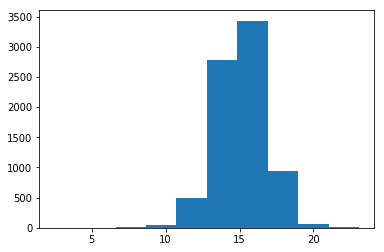

In [448]:
plt.hist(trips_final.SH_trip_ST)